In [23]:
import sys
import warnings
from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# Statsmodels imports
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox

# Configuration
warnings.filterwarnings("ignore")

# Add src to path and import custom utils
sys.path.append('../src')
from utils import compare_metrics, plot_forecasts

print("Libraries loaded.")

Libraries loaded.


In [24]:
df = pd.read_csv('../data/processed/df_stationary.csv', index_col=0, parse_dates=True)

In [25]:
# ENDOGENOUS: All economic variables (Domestic + Global)
# The model will forecast ALL of these simultaneously.
endo_vars = [
    'DLOG_Y_IPI',    # Target
    'X_PPI_Growth',  # Inflation
    'D_X_UNEMP',     # Unemployment
    'DLOG_X_OIL',    # Global Oil (modeled as feedback)
    'LOG_X_CLI'      # Global Sentiment (modeled as feedback)
]

# EXOGENOUS: Only the Dummies (Deterministic Shocks)
# These are known fixed values (0 in the future).
exog_vars = ['D_COVID', 'D_2008']

# Train/Test Split
n_obs = len(df)
n_test = int(n_obs * 0.20)
test_start_index = n_obs - n_test

actual_levels = np.exp(df['LOG_Y_IPI'].iloc[test_start_index:])

print(f"Test Set Size: {n_test} months")
print(f"Split Date: {df.index[test_start_index]}")

Test Set Size: 54 months
Split Date: 2018-06-01 00:00:00


## VAR-X model

### Best lag Selection

Before running the loop, we check the optimal lag order ($p$) on the training data to avoid data leakage.

In [26]:
# Initialize history
history_endo = df[endo_vars].iloc[:test_start_index].copy()
history_exog = df[exog_vars].iloc[:test_start_index].copy()

# Find target column index
target_col_idx = endo_vars.index('DLOG_Y_IPI')

# Select lag order once
initial_model = VAR(history_endo, exog=history_exog)
lag_selection = initial_model.select_order(maxlags=12)
optimal_lag = lag_selection.aic
print("The optimal lag is:",optimal_lag)

The optimal lag is: 4


So we will run $VAR-X(4)$ but also $VAR-X(1)$ since easier models usually perform better

### Residual Diagnostic

In [27]:
lag_to_test = 12

#### VAR-X(1)

In [28]:
varx_1 = VAR(history_endo, exog = history_exog).fit(1)

print("DIAGNOSTIC CHECK VAR-X(1)")
print("="*50)

# IMPORTANT: Remove the first residual (initialization artifact)
residuals_var = varx_1.resid['DLOG_Y_IPI']

# -------------------------------------------------------
# CHECK 1: ZERO MEAN (T-Test)
# -------------------------------------------------------
t_stat, p_value_mean = stats.ttest_1samp(residuals_var, 0)

print(f"Mean of Residuals: {residuals_var.mean():.5f}")
print(f"T-Test P-value:    {p_value_mean:.5f}")

if p_value_mean < 0.05:
    print("❌ Bias Check: FAIL (Mean is significantly different from 0)")
else:
    print("✅ Bias Check: PASS (Mean is effectively 0)")

print("-" * 30)

# -------------------------------------------------------
# CHECK 2: NO AUTOCORRELATION (Ljung-Box Q Test)
# -------------------------------------------------------
lb_result = acorr_ljungbox(residuals_var, lags=[lag_to_test], return_df=True)
p_value_lb = lb_result['lb_pvalue'].iloc[0]

print(f"Ljung-Box (Lag {lag_to_test}) P-value: {p_value_lb:.5f}")

if p_value_lb < 0.05:
    print("❌ Correlation Check: FAIL (Residuals are correlated)")
else:
    print("✅ Correlation Check: PASS (Residuals look like White Noise)")

DIAGNOSTIC CHECK VAR-X(1)
Mean of Residuals: 0.00000
T-Test P-value:    1.00000
✅ Bias Check: PASS (Mean is effectively 0)
------------------------------
Ljung-Box (Lag 12) P-value: 0.14881
✅ Correlation Check: PASS (Residuals look like White Noise)


#### VAR-X(4)

In [29]:
varx_4 = VAR(history_endo, exog = history_exog).fit(optimal_lag)

print("DIAGNOSTIC CHECK VAR-X(4)")
print("="*50)

# IMPORTANT: Remove the first residual (initialization artifact)
residuals_var_4 = varx_4.resid['DLOG_Y_IPI']

# -------------------------------------------------------
# CHECK 1: ZERO MEAN (T-Test)
# -------------------------------------------------------
t_stat, p_value_mean = stats.ttest_1samp(residuals_var_4, 0)

print(f"Mean of Residuals: {residuals_var_4.mean():.5f}")
print(f"T-Test P-value:    {p_value_mean:.5f}")

if p_value_mean < 0.05:
    print("❌ Bias Check: FAIL (Mean is significantly different from 0)")
else:
    print("✅ Bias Check: PASS (Mean is effectively 0)")

print("-" * 30)

# -------------------------------------------------------
# CHECK 2: NO AUTOCORRELATION (Ljung-Box Q Test)
# -------------------------------------------------------
lb_result = acorr_ljungbox(residuals_var_4, lags=[lag_to_test], return_df=True)
p_value_lb = lb_result['lb_pvalue'].iloc[0]

print(f"Ljung-Box (Lag {lag_to_test}) P-value: {p_value_lb:.5f}")

if p_value_lb < 0.05:
    print("❌ Correlation Check: FAIL (Residuals are correlated)")
else:
    print("✅ Correlation Check: PASS (Residuals look like White Noise)")

DIAGNOSTIC CHECK VAR-X(4)
Mean of Residuals: 0.00000
T-Test P-value:    1.00000
✅ Bias Check: PASS (Mean is effectively 0)
------------------------------
Ljung-Box (Lag 12) P-value: 0.60611
✅ Correlation Check: PASS (Residuals look like White Noise)


Since both pass both tests we will select the VAR-X(1) being a way simpler model

### Expanding-Window Training

In [30]:
# CRITICAL: Clear lists before running the loop
preds_growth = []
preds_level = []

for t in range(len(actual_levels)):
    # Fit Model
    model = VAR(history_endo, exog=history_exog)
    model_fit = model.fit(optimal_lag)
    
    # Prepare Inputs
    last_obs = history_endo.values[-optimal_lag:]
    next_idx = test_start_index + t
    future_exog = df[exog_vars].iloc[next_idx].values.reshape(1, -1)
    
    # Forecast Growth
    fc = model_fit.forecast(y=last_obs, exog_future=future_exog, steps=1)
    pred_growth = fc[0, target_col_idx]
    
    # Reconstruct Level: exp( Last_Actual_Log_Level + Predicted_Growth )
    last_actual_log_level = df['LOG_Y_IPI'].iloc[next_idx - 1]
    pred_level = np.exp(last_actual_log_level + pred_growth)
    
    preds_level.append(pred_level)
    
    # Update History
    next_row_endo = df[endo_vars].iloc[next_idx]
    next_row_exog = df[exog_vars].iloc[next_idx]
    history_endo.loc[next_row_endo.name] = next_row_endo
    history_exog.loc[next_row_exog.name] = next_row_exog

print(f"Forecast Complete. Predictions generated: {len(preds_level)}")

Forecast Complete. Predictions generated: 54


In [31]:
preds_level_1 = []
pred_growth_1= []

history_endo_1 = df[endo_vars].iloc[:test_start_index].copy()
history_exog_1 = df[exog_vars].iloc[:test_start_index].copy()

for t in range(len(actual_levels)):
    # Fit Model
    model = VAR(history_endo_1, exog=history_exog_1)
    model_fit = model.fit(1)
    
    # Prepare Inputs
    last_obs = history_endo_1.values[-1:]
    next_idx = test_start_index + t
    future_exog = df[exog_vars].iloc[next_idx].values.reshape(1, -1)
    
    # Forecast Growth
    fc = model_fit.forecast(y=last_obs, exog_future=future_exog, steps=1)
    pred_growth_1= fc[0, target_col_idx]
    
    # Reconstruct Level: exp( Last_Actual_Log_Level + Predicted_Growth )
    last_actual_log_level = df['LOG_Y_IPI'].iloc[next_idx - 1]
    pred_level = np.exp(last_actual_log_level + pred_growth)
    
    preds_level_1.append(pred_level)
    
    # Update History
    next_row_endo = df[endo_vars].iloc[next_idx]
    next_row_exog = df[exog_vars].iloc[next_idx]
    history_endo_1.loc[next_row_endo.name] = next_row_endo
    history_exog_1.loc[next_row_exog.name] = next_row_exog

print(f"Forecast Complete. Predictions generated: {len(preds_level_1)}")

Forecast Complete. Predictions generated: 54


In [32]:
# Benchmark (Random Walk)

# Shift actual levels by 1 to simulate "Tomorrow = Today"
pred_rw_level = actual_levels.shift(1)
pred_rw_level.iloc[0] = np.exp(df['LOG_Y_IPI'].iloc[test_start_index - 1])

### Evaluation

In [33]:
# Create series with correct index
pred_var_4 = pd.Series(preds_level, index=actual_levels.index)
pred_var_1 = pd.Series(preds_level_1, index=actual_levels.index)

preds_dict = {
    'VAR-X(1)': pred_var_1,
    'VAR-X(4)': pred_var_4,
    'Random Walk': pred_rw_level
}

print("\n--- Final Evaluation (RMSE on Original Levels) ---")
metrics_df = compare_metrics(actual_levels, preds_dict, benchmark_name= "Random Walk")
print(metrics_df)


--- Final Evaluation (RMSE on Original Levels) ---
                  RMSE       MAE  RMSFE Ratio  MAFE Ratio
Random Walk   6.235937  3.039524     1.000000    1.000000
VAR-X(1)      6.304961  3.160717     1.011069    1.039872
VAR-X(4)     10.427251  4.502877     1.672123    1.481441


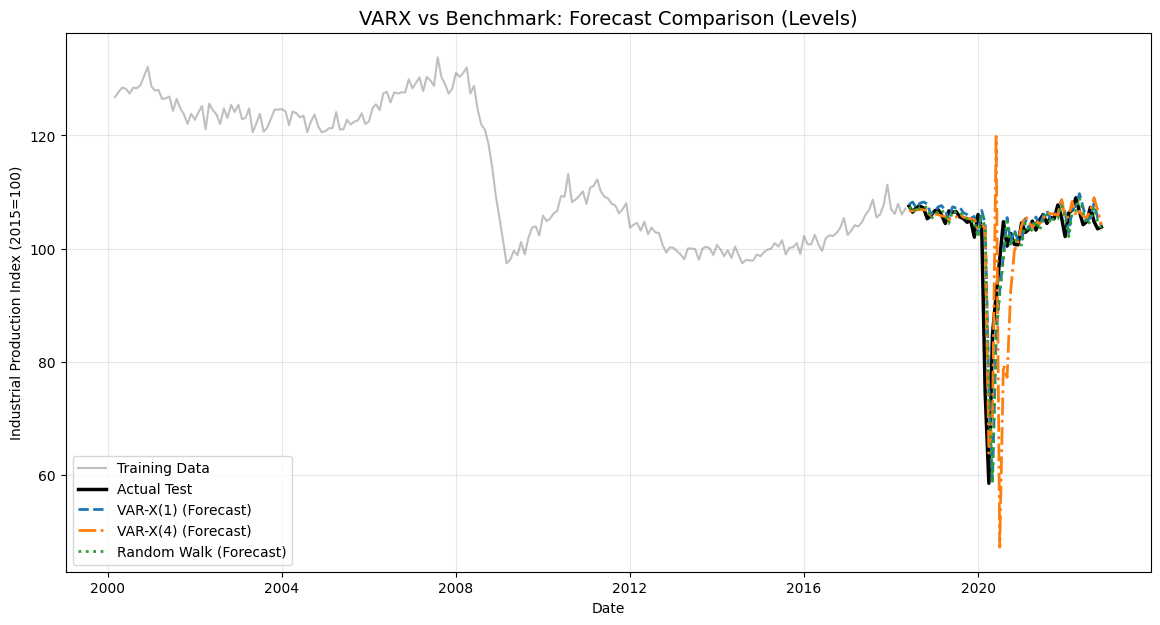

In [34]:
plot_forecasts(
    test=actual_levels,
    predictions_dict=preds_dict,
    train=np.exp(df['LOG_Y_IPI'].iloc[:test_start_index]),
    title="VARX vs Benchmark: Forecast Comparison (Levels)",
    ylabel="Industrial Production Index (2015=100)"
)

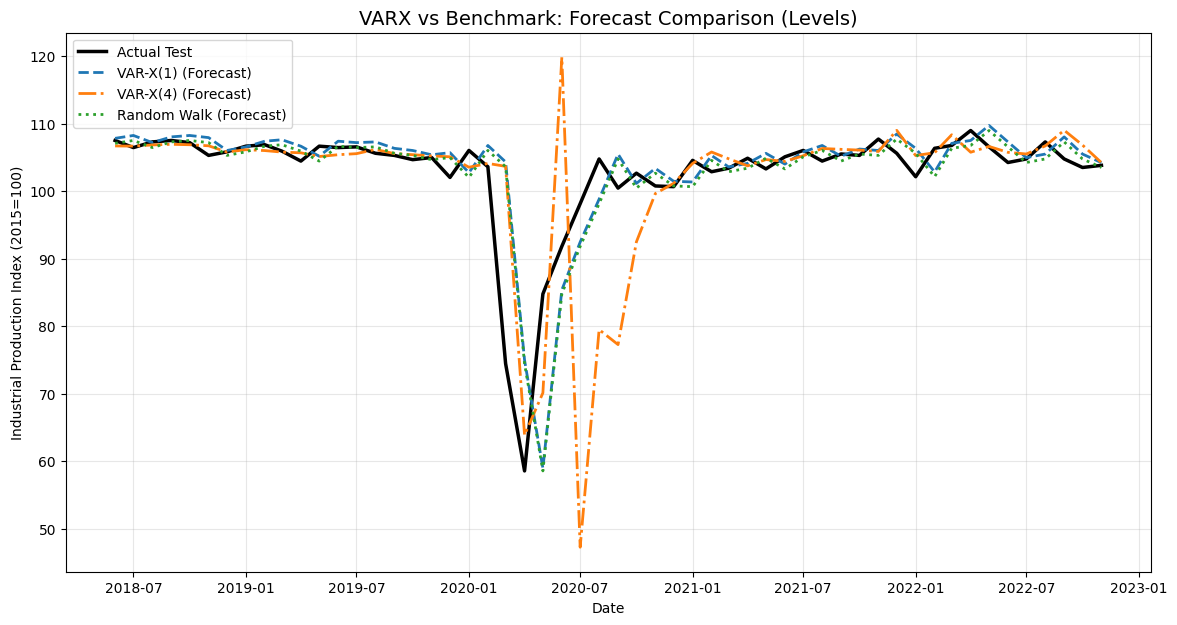

In [35]:
plot_forecasts(
    test=actual_levels,
    predictions_dict=preds_dict,
    train=None,
    title="VARX vs Benchmark: Forecast Comparison (Levels)",
    ylabel="Industrial Production Index (2015=100)"
)

1. VAR-X(1) Model $$y_t = c + \Phi_1 * y_{t-1} + B * x_t + epsilon_t$$

2. VAR-X(4) Model $$y_t = c + \Phi_1 * y_{t-1} + \Phi_2 * y_{t-2} + \Phi_3 * y_{t-3} + \Phi_4 * y_{t-4} + B * x_t + epsilon_t$$

Variables:

- $y_t = [IPI_{Growth_t}, PPI_{Growth_t}, Unemp_t, Oil_{Price_t}, Sentiment_t]^T$
- $x_t = [D_{COVID_t}, D_{2008_t}]^T$
- $y_{t-k}$ represents the vector of economic variables lagged by k months.
- $\Phi_k$ represents the coefficient matrix for the k-th lag.
- $B$ is the coefficient matrix for the exogenous dummies.
- $c$ is the constant vector.
- $epsilon_t$ is the white noise error vector.

# Dynamic Factor Model

To prepare the high-dimensional dataset for Factor Analysis, all series were transformed to ensure stationarity (mostly via first-differencing, with rates kept in levels). Missing observations at the sample edges ("ragged edges") were imputed using the Stock & Watson (2002) EM algorithm, with the number of factors determined by the Bai and Ng (2002) criterion. No manual outlier adjustments were performed.

In [36]:
# 1. Load Target (Stationary)
df_target = pd.read_csv('../data/processed/df_stationary.csv', index_col=0, parse_dates=True)
target_series = df_target['DLOG_Y_IPI']

# 2. Load & Filter Macro Data
# We load the raw excel
df_macro_raw = pd.read_excel("../data/factor_data/ITdata_TR2.xlsx", parse_dates=True)

# Rename Time column if needed (assuming 'Time' or similar exists, or index is date)
if 'Time' in df_macro_raw.columns:
    df_macro_raw = df_macro_raw.set_index('Time')

# Define the specific Monthly Variables (Italy)
monthly_base_variables = [
    "UNETOT", "UNEO25", "UNEU25", "REER42", "ERUS", "SHIX", "IRT3M", "IRT6M", "LTIRT",
    "TRNMN", "TRNCAG", "TRNCOG", "TRNDCOG", "TRNNDCOG", "TRNING", "TRNNRG", "CAREG",
    "PPICAG", "PPICOG", "PPIDCOG", "PPINDCOG", "PPING", "PPINRG",
    "HICPOV", "HICPNEF", "HICPG", "HICPIN", "HICPSV", "HICPNG",
    "ICONFIX", "CCONFIX", "ESENTIX", "KCONFIX", "RTCONFIX", "SCONFIX", "BCI", "CCI",
    "CURR", "M1", "M2"
]
# Add suffix
monthly_vars_IT = [f"{var}_IT" for var in monthly_base_variables]

# Filter dataset
valid_cols = [c for c in monthly_vars_IT if c in df_macro_raw.columns]
df_macro = df_macro_raw[valid_cols].copy()

# 4. Align Dates
common_index = df_macro.index.intersection(target_series.index)
X_all = df_macro.loc[common_index]
y_all = target_series.loc[common_index]

print(f"Final Dataset Shape: X={X_all.shape}, y={y_all.shape}")
print(f"Variables included: {len(valid_cols)}")

Final Dataset Shape: X=(273, 31), y=(273,)
Variables included: 31


In [37]:
# Define Split (20% Test)
n_obs = len(y_all)
n_test = int(n_obs * 0.20)
train_end_idx = n_obs - n_test

# Split Data
X_train = X_all.iloc[:train_end_idx]
y_train = y_all.iloc[:train_end_idx]

print(f"Training Set: {X_train.index.min().date()} to {X_train.index.max().date()}")

Training Set: 2000-03-01 to 2018-05-01


## Dynamic Factor VAR(p)

### PCA on train data (Selection of number of Factors )

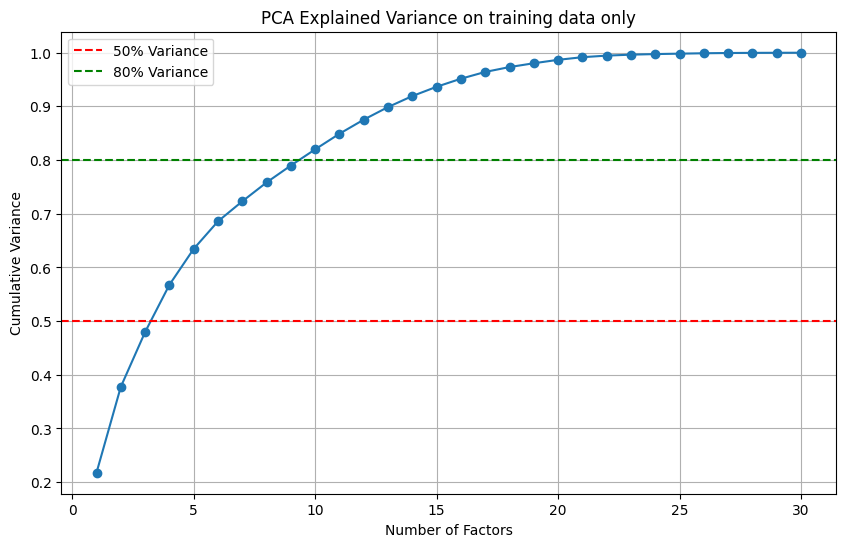

Selected Number of Factors: 1
Variance Explained by 1 factors: 21.75%


In [38]:
# 1. Standardize Training Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# 2. Run PCA on Train
pca = PCA(n_components= 30)
pca.fit(X_train_scaled)

# 3. Scree Plot (Explained Variance)
explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.axhline(y=0.50, color='r', linestyle='--', label='50% Variance')
plt.axhline(y=0.80, color='g', linestyle='--', label='80% Variance')
plt.title('PCA Explained Variance on training data only')
plt.xlabel('Number of Factors')
plt.ylabel('Cumulative Variance')
plt.legend()
plt.grid()
plt.show()

# DECISION: How many factors?
# Let's pick the number that explains ~60-70% variance, or default to 3
N_FACTORS = 1
print(f"Selected Number of Factors: {N_FACTORS}")
print(f"Variance Explained by {N_FACTORS} factors: {explained_var[N_FACTORS-1]:.2%}")

**we select only one factor, since it seems to be performing better than using more**

### In-Sample Diagnostics (Static Model)

In [39]:
# 1. Extract Factors (Train)
pca_static = PCA(n_components=N_FACTORS)
F_train = pca_static.fit_transform(X_train_scaled)
df_F_train = pd.DataFrame(F_train, index=X_train.index, columns=[f'F{i+1}' for i in range(N_FACTORS)])

# 2. Form the System [Target, Factors]
# We combine them into one dataframe for the VAR
df_system_train = pd.concat([y_train, df_F_train], axis=1)

# 3. Fit VAR(1)
# This estimates equations for Y and for F simultaneously
model_static = VAR(df_system_train)
results_static = model_static.fit(1)

# 4. Get Residuals for the Target (Index 0)
# The VAR stores residuals for all variables. We only care about DLOG_Y_IPI (col 0)
residuals = results_static.resid['DLOG_Y_IPI']

# 5. Diagnostic Tests
print("\n=== IN-SAMPLE DIAGNOSTICS (VAR(1) on Training Data) ===")

# A. T-Test for Zero Mean
t_stat, p_val_mean = stats.ttest_1samp(residuals, 0)
print(f"T-Test (Zero Mean): P-Value = {p_val_mean:.4f}")
if p_val_mean > 0.05: print("  ✅ PASS: Residuals mean is not significantly different from 0.")
else: print("  ❌ FAIL: Residuals have a non-zero mean (Bias).")

# B. Ljung-Box (Autocorrelation)
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
lb_pvalue = lb_test['lb_pvalue'].values[0]
print(f"Ljung-Box (No Autocorr): P-Value = {lb_pvalue:.4f}")
if lb_pvalue > 0.05: print("  ✅ PASS: No significant autocorrelation.")
else: print("  ❌ FAIL: Autocorrelation found.")


=== IN-SAMPLE DIAGNOSTICS (VAR(1) on Training Data) ===
T-Test (Zero Mean): P-Value = 1.0000
  ✅ PASS: Residuals mean is not significantly different from 0.
Ljung-Box (No Autocorr): P-Value = 0.0715
  ✅ PASS: No significant autocorrelation.


### Expanding Window Forecast (Dynamic Factor VAR)

In [40]:
print(f"\nStarting Dynamic Factor VAR(1) Forecast (Expanding Window)...")

preds_growth = []
preds_level = []

# Expanding Window Loop
for t in range(n_test):
    # 1. Define Window
    curr_end = train_end_idx + t
    X_window = X_all.iloc[:curr_end]
    y_window = y_all.iloc[:curr_end]
    
    # 2. Standardize & PCA (Re-calculated every step to avoid leakage)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_window)
    
    pca = PCA(n_components=N_FACTORS)
    F_window = pca.fit_transform(X_scaled)
    df_F = pd.DataFrame(F_window, index=X_window.index, columns=[f'F{i+1}' for i in range(N_FACTORS)])
    
    # 3. Form System [Target, Factors]
    df_system = pd.concat([y_window, df_F], axis=1)
    
    # 4. Fit VAR(1)
    model = VAR(df_system)
    model_fit = model.fit(1)
    
    # 5. Forecast Next Step
    # We use the last available observation (lag) to predict t+1
    # .values[-1:] gets the last row as a 2D array (1, k)
    last_obs = df_system.values[-1:]
    
    fc = model_fit.forecast(y=last_obs, steps=1)
    
    # Extract predicted Y (Column 0 is DLOG_Y_IPI)
    pred_g = fc[0, 0]
    preds_growth.append(pred_g)
    
    # 6. Reconstruct Level
    # Get previous actual log level to apply growth to
    # pred_date corresponds to y_all.index[curr_end]
    pred_date = y_all.index[curr_end]
    prev_log_level = df_target.loc[:pred_date]['LOG_Y_IPI'].iloc[-2]
    
    pred_l = np.exp(prev_log_level + pred_g)
    preds_level.append(pred_l)
    
    # Progress
    if t % 10 == 0:
        print(f"Step {t}/{n_test} complete...")

print("Forecast Complete.")


Starting Dynamic Factor VAR(1) Forecast (Expanding Window)...
Step 0/54 complete...
Step 10/54 complete...
Step 20/54 complete...
Step 30/54 complete...
Step 40/54 complete...
Step 50/54 complete...
Forecast Complete.


At the end, we've tried performing forecasting with both 1,2 and 3 Factors, and the result is that only preserving the first the result turned out to be better, aligning with the knowledge that a simpler method performs better (Parsimony)

## Dynamic Factor with Dummies: Factor VAR-X(1)

In [41]:
preds_growth_x = []
preds_level_x = []

# 1. Prepare Dummies
# We need to make sure they are available for the whole timeline
if 'D_COVID' not in df_target.columns:
    df_target['D_COVID'] = 0
    df_target.loc['2020-03-01':'2020-04-01', 'D_COVID'] = 1
    df_target['D_2008'] = 0
    df_target.loc['2008-11-01':'2009-04-01', 'D_2008'] = 1

# 2. Expanding Window Loop
for t in range(n_test):
    # --- Define Window ---
    curr_end = train_end_idx + t
    X_window = X_all.iloc[:curr_end]
    y_window = y_all.iloc[:curr_end]
    
    # Get Dummies for the training window (aligned with y_window)
    # We use the index of y_window to slice the dummies correctly
    exog_train = df_target.loc[y_window.index, ['D_COVID', 'D_2008']]
    
    # --- Standardize & PCA ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_window)
    
    pca = PCA(n_components=N_FACTORS)
    F_window = pca.fit_transform(X_scaled)
    df_F = pd.DataFrame(F_window, index=X_window.index, columns=[f'F{i+1}' for i in range(N_FACTORS)])
    
    # --- Form System [Target, Factors] ---
    df_system = pd.concat([y_window, df_F], axis=1)
    
    # --- Fit VARX(1) ---
    # endog=[Y, F], exog=[Dummies]
    model = VAR(df_system, exog=exog_train)
    model_fit = model.fit(1)
    
    # --- Forecast Next Step ---
    # Input 1: Last observations of Endogenous [Y, F]
    last_obs = df_system.values[-1:]
    
    # Input 2: Future Exogenous (Dummy at t+1)
    # The date we are predicting
    pred_date = y_all.index[curr_end]
    
    # Extract dummy values for that specific date
    # We wrap in .values.reshape(1,-1) to get shape (1, 2)
    exog_future = df_target.loc[pred_date, ['D_COVID', 'D_2008']].values.reshape(1, -1)
    
    # Predict
    fc = model_fit.forecast(y=last_obs, steps=1, exog_future=exog_future)
    
    # Extract predicted Y (Column 0)
    pred_g = fc[0, 0]
    preds_growth_x.append(pred_g)
    
    # --- Reconstruct Level ---
    prev_date = y_all.index[curr_end - 1]
    prev_log_level = df_target.loc[prev_date, 'LOG_Y_IPI']
    
    pred_l = np.exp(prev_log_level + pred_g)
    preds_level_x.append(pred_l)

print("FAVAR-X Forecast Complete.")

FAVAR-X Forecast Complete.



=== FINAL FACTOR MODEL RESULTS ===
                              RMSE       MAE  RMSFE Ratio  MAFE Ratio
Random Walk               6.235937  3.039524     1.000000    1.000000
Dynamic Factor VAR-X(1)   6.716463  3.088377     1.077058    1.016073
Dynamic Factor VAR(1)     6.965066  3.264461     1.116924    1.074004


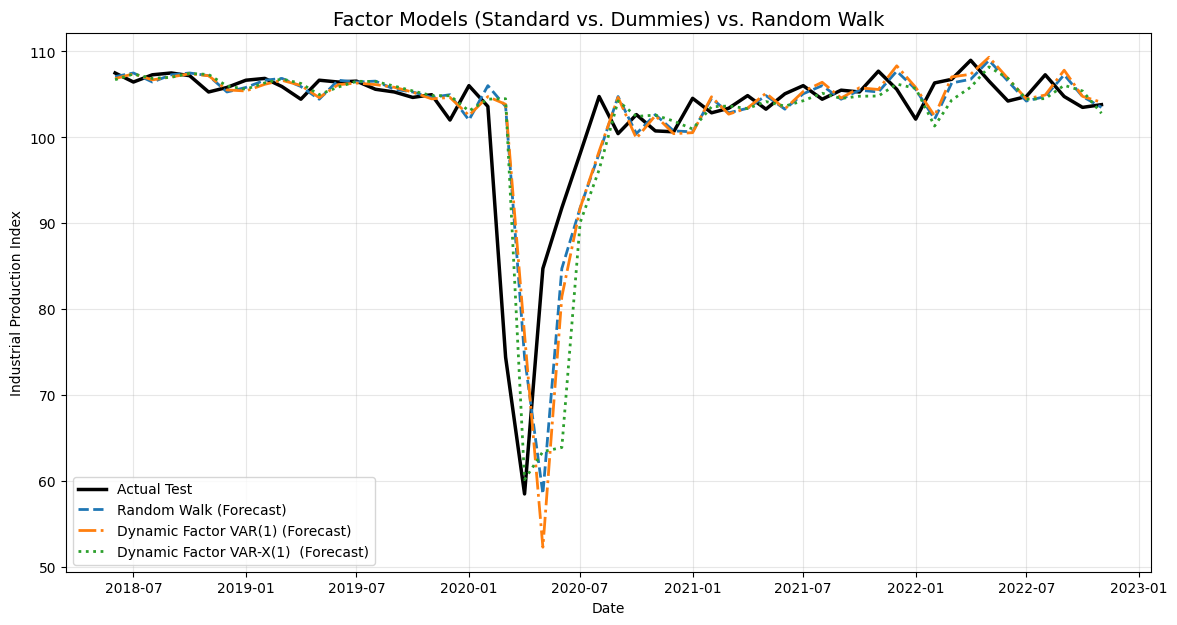

In [42]:

actual_levels = np.exp(df_target['LOG_Y_IPI'].iloc[train_end_idx:])
pred_series = pd.Series(preds_level, index=actual_levels.index)
pred_series_x = pd.Series(preds_level_x, index=actual_levels.index)


# (Assuming 'pred_series' from the standard DFM and 'pred_rw' exist from previous cells)
preds_dict_final = {
    'Random Walk': pred_rw_level,
    'Dynamic Factor VAR(1)': pred_series,
    'Dynamic Factor VAR-X(1) ': pred_series_x
}

# 3. Metrics
print("\n=== FINAL FACTOR MODEL RESULTS ===")
metrics_final = compare_metrics(actual_levels, preds_dict_final, benchmark_name= "Random Walk")
print(metrics_final)

# 4. Plot
plot_forecasts(
    actual_levels, 
    preds_dict_final, 
    title="Factor Models (Standard vs. Dummies) vs. Random Walk",
    ylabel="Industrial Production Index"
)

- FAVAR(1) without Dummies (Standard)
In this case, the forecast depends only on the autoregressive terms and the factor terms.
$$y_t = c + \rho_1 y_{t-1} + \lambda_1 \hat{F}_{1,t-1} + \epsilon_t$$

-  FAVAR-X(1) with Dummies (Exogenous)
In this case, we add the exogenous dummy variables $\mathbf{x}_t$ (Covid, 2008 Crisis) to the equation to capture structural breaks.
 $$y_t = c + \rho_1 y_{t-1} + \lambda_1 \hat{F}_{1,t-1} + \beta_1 D_{\text{COVID},t} + \beta_2 D_{2008,t} + \epsilon_t$$

# Final Evaluation


=== FINAL FACTOR MODEL RESULTS ===
                               RMSE       MAE  RMSFE Ratio  MAFE Ratio
Random Walk                6.235937  3.039524     1.000000    1.000000
VAR-X(1)                   6.304961  3.160717     1.011069    1.039872
Dynamic Factor VAR-X(1)    6.716463  3.088377     1.077058    1.016073
Dynamic Factor VAR(1)      6.965066  3.264461     1.116924    1.074004
VAR-X(4)                  10.427251  4.502877     1.672123    1.481441


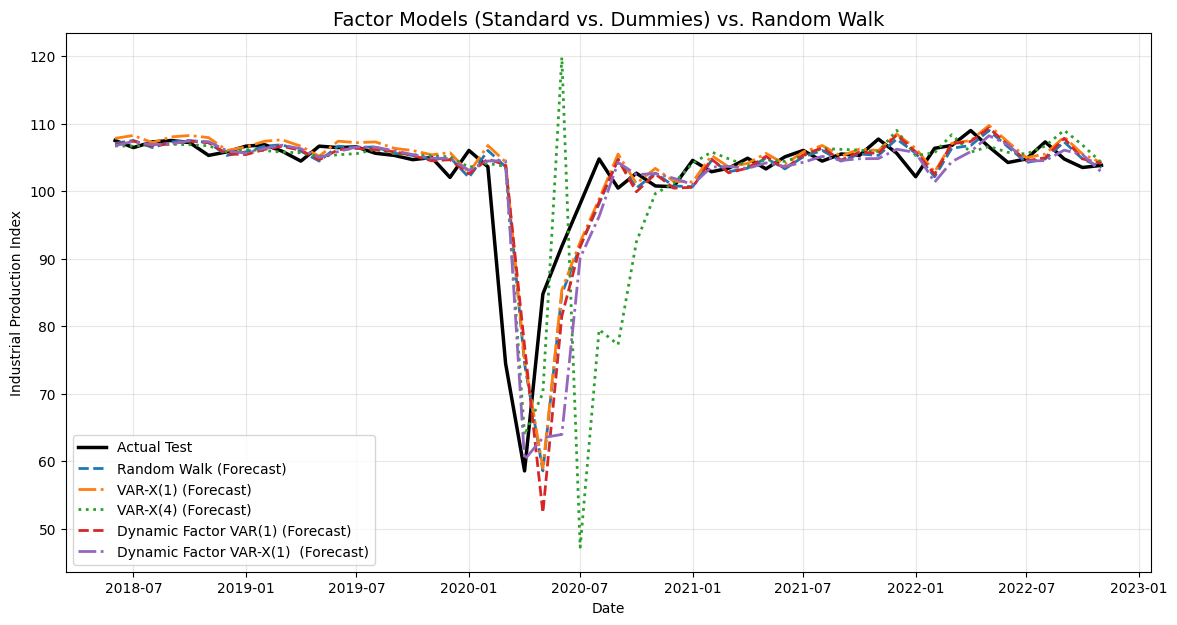

In [44]:
preds_dict = {
    'Random Walk': pred_rw_level,
    'VAR-X(1)': pred_var_1,
    'VAR-X(4)': pred_var_4,
    'Dynamic Factor VAR(1)': pred_series,
    'Dynamic Factor VAR-X(1) ': pred_series_x
}

# 3. Metrics
print("\n=== FINAL FACTOR MODEL RESULTS ===")
metrics_final = compare_metrics(actual_levels, preds_dict, benchmark_name= "Random Walk")
print(metrics_final)

# 4. Plot
plot_forecasts(
    actual_levels, 
    preds_dict, 
    title="Factor Models (Standard vs. Dummies) vs. Random Walk",
    ylabel="Industrial Production Index"
)